In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import astropy.io.ascii as aia
import bz2
import glob
import pickle
import pystan
import re
import scipy.optimize as so
import scipy.stats as ss
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Mini}{M_\mathrm{ini}}
\newcommand{\MSun}{M_\odot}
\newcommand{\Myr}{\mathrm{Myr}}
$$

Settings for publication quality figures.

In [2]:
colwidth = 245.26653/72 # inches

pubplotsize = (colwidth,colwidth)

pubrc = {
    'text.usetex': True,
    'font.family': 'serif',
    'figure.figsize': pubplotsize
}

# Re-Analysis of Schneider+ IMF Data

## Setup, Model

[Schneider, et al. (2018)](https://dx.doi.org/10.1126/science.aan0106) report on an analysis of the stellar parameters of massive stars in 30 Dor that suggests that the high-mass end of the IMF contains more stars than suggested by a Salpeter IMF (i.e. the power-law is shallower than $\diff{N}{M} \propto M^{-2.35}$, more like $\diff{N}{M} \propto M^{-1.9}$).  However, their analysis rests on summing the posteriors of stellar parameters for their sample of observed stars!  Therefore, the distributions they obtain for stellar ages and stellar masses represent the *convolution* of the true distributions for these quantities with observational errors (see, e.g. [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract)); convolving a (broad---See Fig 1 from Schneider, et al. (2018)) observational uncertainty with a steep power law tends to shallow the power law at the high mass end, suggesting that their differences with Salpeter may (at least partly) be a result of their flawed statistical approach.

Schneider, et al. (2018) should be *commended* for providing the data from their stellar parameter fits.  I downloaded the data.  Then I realised they should also be *reprimanded* for not using a truly machine-readable format!  But no matter; by reading the header and manually putting in column names, I can parse it:

In [3]:
stellar_parameters_all = genfromtxt('aan0106_Data_S1.txt', delimiter='\t', comments='#', usecols=(23,24,25,31,32,33), names=('Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem'))

sel = np.ones(stellar_parameters_all.shape[0], dtype=np.bool)

for n in stellar_parameters_all.dtype.names:
    sel = sel & ~(np.isnan(stellar_parameters_all[n]))

stellar_parameters = stellar_parameters_all[sel]

Here is the data:

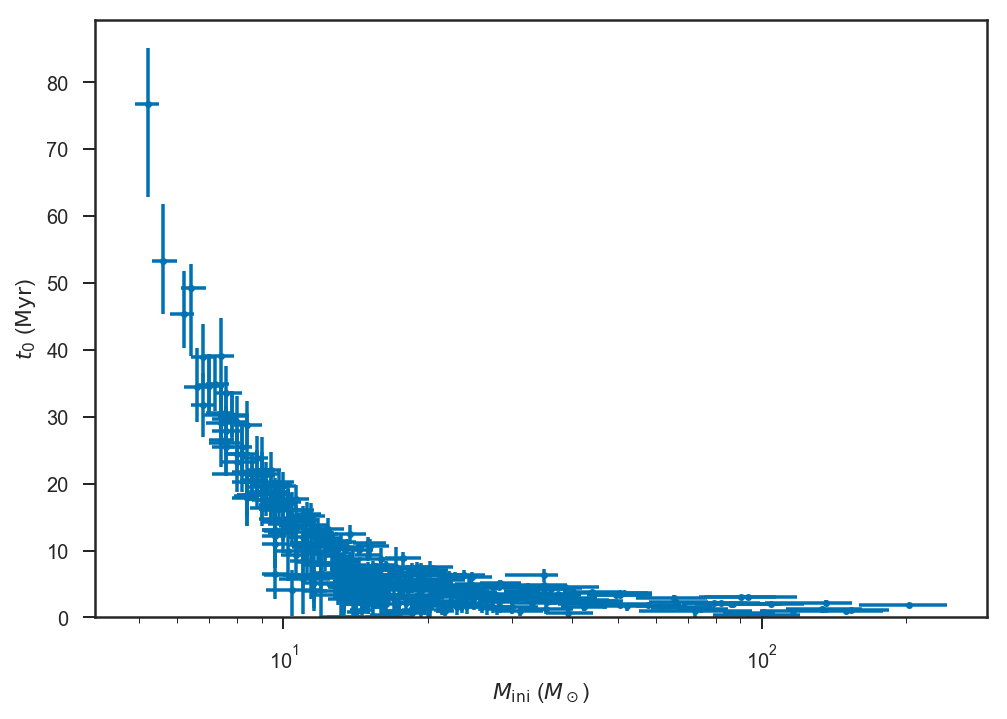

In [4]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', )
axis(ymin=0)
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
savefig('age-mass-all.pdf')

In [5]:
len(stellar_parameters_all), len(stellar_parameters)

(572, 400)

And restricting to $\Mini \geq 15 \, \MSun$:

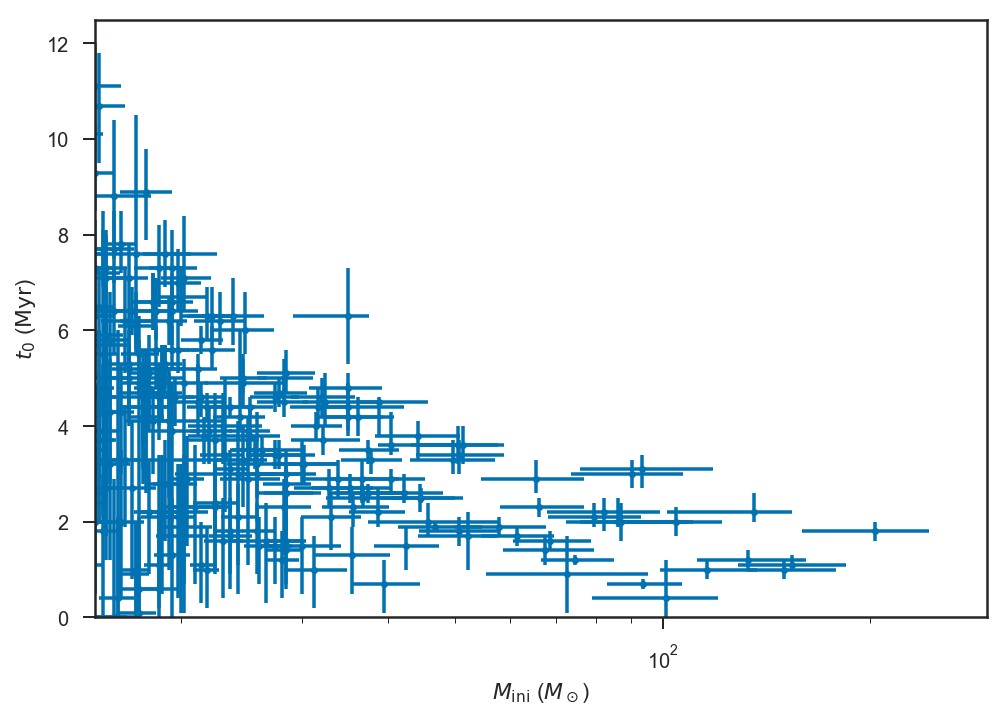

In [6]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.')
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=15, ymin=0, ymax=12.5)
savefig('age-mass-zoom.pdf')

I grabbed the non-rotating evolutionary models from [Brott, et al. (2011)](https://dx.doi.org/10.1051/0004-6361/201016113) from [VizieR](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/530/A115#sRM2.1).  I also grabbed `models.dat`, which gives the masses for the models.

Since 30 Dor has a metallicity around half the solar value, I think it is probably best to use the LMC lifetimes.

In [7]:
masses = []
lifetimes = []
for f in glob.glob('evol/f*.dat'):
    m = float(int(re.match('.*f([0-9]+)-.*', f).group(1)))
    lt = np.max(genfromtxt(f, delimiter='|', usecols=(0,)))
    masses.append(m)
    lifetimes.append(lt)
masses = array(masses)
lifetimes = array(lifetimes)
inds = argsort(masses)
masses = masses[inds]
lifetimes = lifetimes[inds]

The plot below is restricted to $M \geq 15 \, \MSun$.

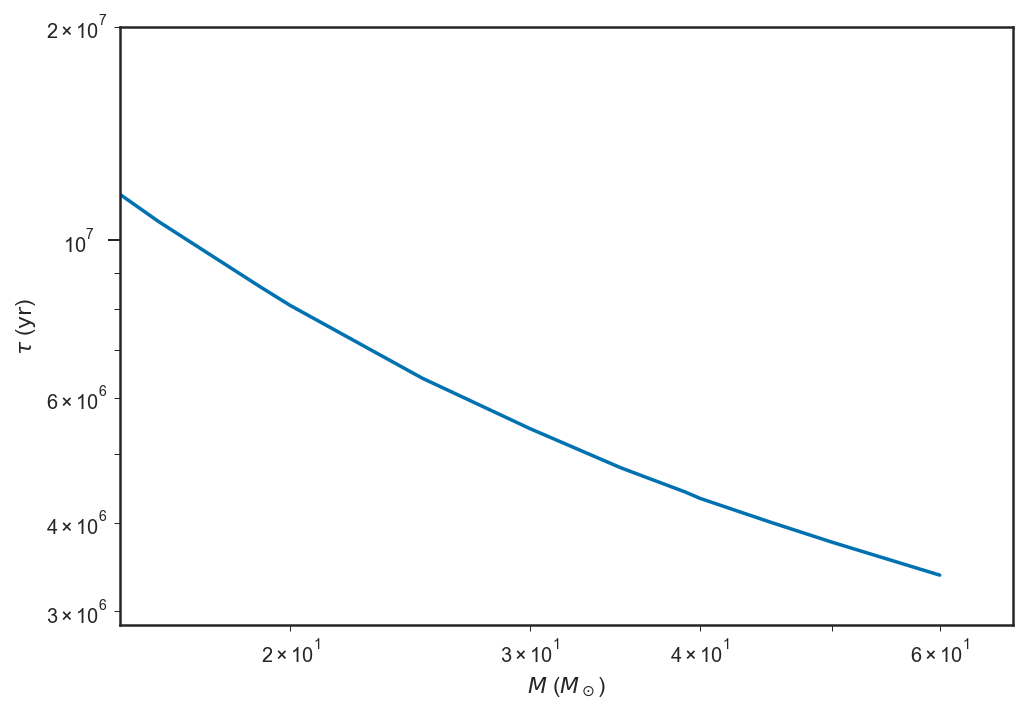

In [8]:
plot(masses, lifetimes)
xscale('log')
yscale('log')
axis(xmin=15, ymax=2e7)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

Let's try to interpret this as a power law (it's not, clearly, but maybe it's close).  Hmm, doesn't look too good:

(15, 57.23700725928984, -1.4, -0.50835948614594062)

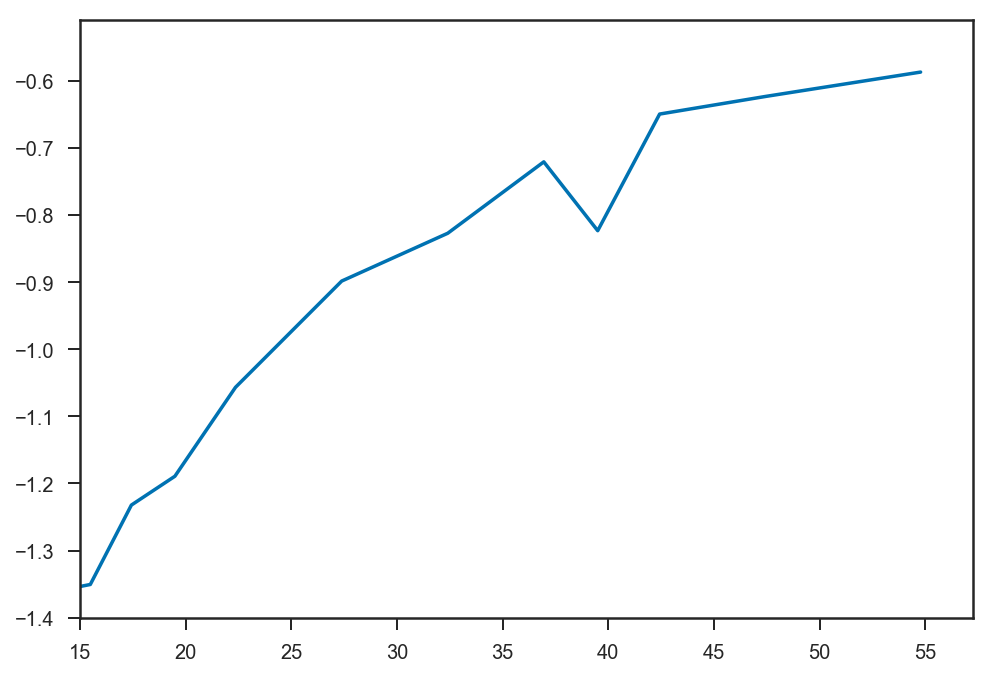

In [9]:
mid_masses = exp(0.5*(log(masses[1:]) + log(masses[:-1])))
plot(mid_masses, diff(log(lifetimes))/diff(log(masses)))
axis(xmin=15, ymin=-1.4)

OK.  How about a log-log fit to polynomials?

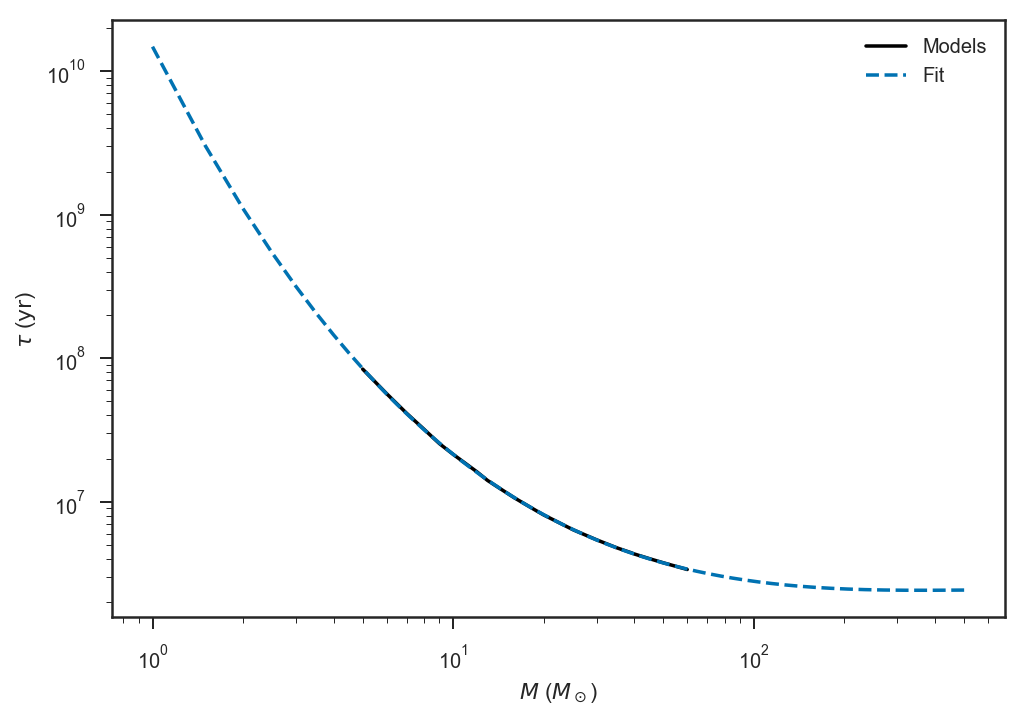

In [10]:
nmasses = masses.shape[0]
M = column_stack((ones(nmasses), log(masses), log(masses)**2, log(masses)**3))
c_lifetime = np.linalg.lstsq(M, log(lifetimes/1e6))[0]
plot(masses, lifetimes, '-k', label='Models')

fit_masses = linspace(1, 500, 1000)
Mfit = column_stack((ones(1000), log(fit_masses), log(fit_masses)**2, log(fit_masses)**3))

plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T))*1e6, '--', label='Fit')
xscale('log')
yscale('log')

legend(loc='best')

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

savefig('lifetime-fit.pdf')

In [11]:
def lifetime(M, cs):
    return np.exp(np.dot([1.0, log(M), log(M)**2, log(M)**3], cs))

Let's compare against the observed sample:

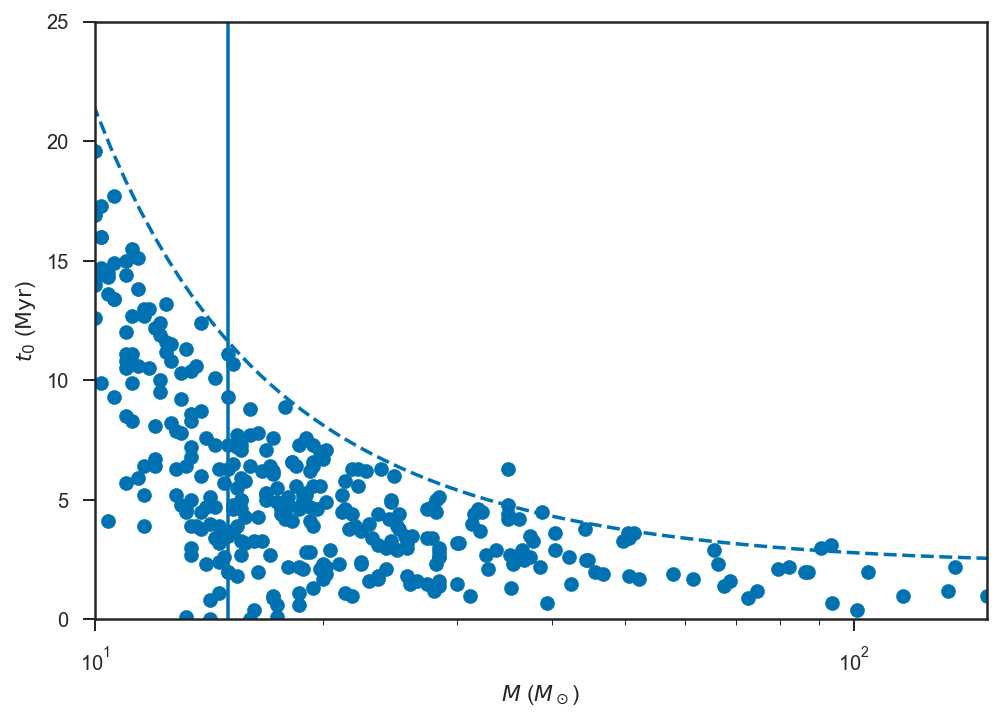

In [12]:
plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T)), '--', label='Fit')
xscale('log')
scatter(stellar_parameters['Mini'], stellar_parameters['age'])

axis(xmin=10, xmax=150, ymax=25, ymin=0)

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')

axvline(15) # Completeness line.

savefig('lifetime-data.pdf')

The model is implemented in `IMF.stan`.  Here are a few notes about how the model works.  First, we use a population model that is 
$$
\diff{N}{M \dd t} = \frac{\Lambda \left( \alpha - 1 \right)}{M_\mathrm{cut}} \left( \frac{M}{M_\mathrm{cut}} \right)^{-\alpha} \frac{N\left( t \mid \mu_t, \sigma_t \right)}{\Phi\left( t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
In words: a power-law mass function and a Gaussian SFR, with expected number of stars formed with ages between $0$ and $t_\mathrm{max}$ of order $\Lambda$ (not extactly $\Lambda$ because some stars will have *true* masses below $M_\mathrm{cut}$).  Parameters are $\Lambda$, $\alpha$, $\mu_t$, $\sigma_t$.  Note that here $M_\mathrm{cut}$ is the cut on the *observed* mass (so the population can extend below $M_\mathrm{cut}$).

We assume that the observational likelihood function is a product of normal distributions for log(mass) and age (independently), with location parameters at the quoted (MAP?) value, and scale parameters that are half the quoted 68% width.  This is lighter-tailed than some of the likelihoods presented in Schneider, et al. (2018), and is also symmetric unlike those distributions, but it is easy to implement.  In simpler models, we have used heavier-tailed distributions and found that the tails did not really influence the fit at all.  

To implement the selection effects, we use direct integration.  We can analytically integrate over the *observable* region in parameter space in age, since the SFR is just a Gaussian (we get a difference of Gaussian CDFs).  Integrating over $M$ is not possible with simple functions, but we can use Stan's ODE computation to solve 
$$
\diff{f_\mathrm{obs}}{M} = \frac{\alpha - 1}{M_\mathrm{cut}} \left( \frac{M}{M_\mathrm{cut}} \right)^{-\alpha} \frac{\Phi\left( t_+(M) \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}{\Phi\left(t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)} P_\mathrm{det}\left( M \right)
$$
where $t_+(M)$ is the maximum lifetime for *observable* systems at mass $M$; $P_\mathrm{det}\left( M \right)$ is the probability that a system with true mass $M$ will be detected: 
$$
P_\mathrm{det}(M) \equiv \int_{M_\mathrm{cut}}^\infty \dd M_\mathrm{obs} \, p\left( M_\mathrm{obs} \mid M \right),
$$
which can be written in terms of the CDF for the normal distribution governing $\log M_\mathrm{obs}$; and 
$f_\mathrm{obs}(\infty) \Lambda$ is the number of stars that are *observable*, using the initial condition that $f_\mathrm{obs}\left( M_\mathrm{min} \right) = 0$ (where $M_\mathrm{min}$ is some lower mass---the integrand is singular at $M = 0$---that is sufficiently small that $P_\mathrm{det}\left( M_\mathrm{min} \right) \simeq 0$).  The normalising term in the inhomogeneous Poisson distribution is then 
$$
\exp\left[ -\Lambda f_\mathrm{obs}(\infty) \right],
$$
or the exponential of the expected number of *observed* systems.

Note that for sufficiently large uncertainties or steep slopes it can happen that $f_\mathrm{obs}(\infty) > 1$.

To construct the likelihood described above, we produce fictituous $M_\mathrm{obs}$ and uncertainties so the likelihood is normal for $\log M$ and $t$ with the quoted 68% interval.

In [13]:
mupper = stellar_parameters['Mini'] + stellar_parameters['dMinip']
mlower = stellar_parameters['Mini'] - stellar_parameters['dMinim']

logm_obs = log(stellar_parameters['Mini'])
sigma_logm_obs = 0.5*(log(mupper) - log(mlower))

tupper = stellar_parameters['age'] + stellar_parameters['dagep']
tlower = stellar_parameters['age'] - stellar_parameters['dagem']

t_obs = stellar_parameters['age']
sigma_t_obs = 0.5*(tupper - tlower)

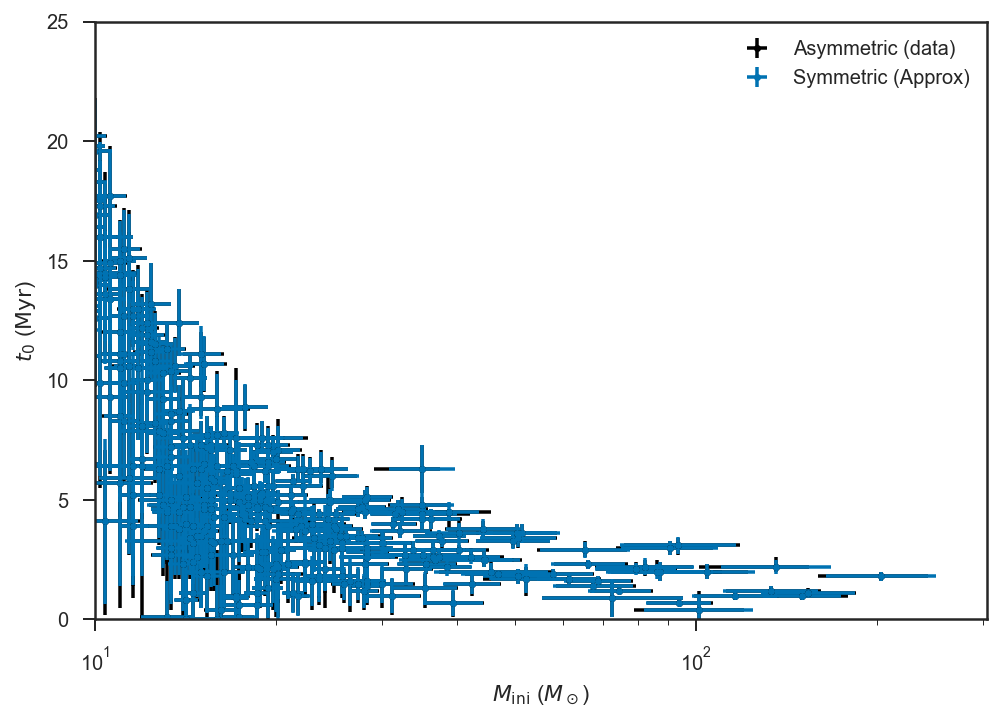

In [14]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', color='k', label="Asymmetric (data)")
errorbar(exp(logm_obs), t_obs, yerr=sigma_t_obs, xerr=(exp(logm_obs)-exp(logm_obs - sigma_logm_obs), -exp(logm_obs) + exp(logm_obs+sigma_logm_obs)), fmt='.', color=sns.color_palette()[0], label="Symmetric (Approx)")
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=10, ymin=0, ymax=25)
legend(loc='best')

We need to estimate the typical uncertainty of the observations near $M_\mathrm{min}$ so that we can implement the selection effect integral above.  Here is a plot of the uncertainty in $\log M$ versus $M$:

Median (i.e. typical) sigma_logm is 0.08


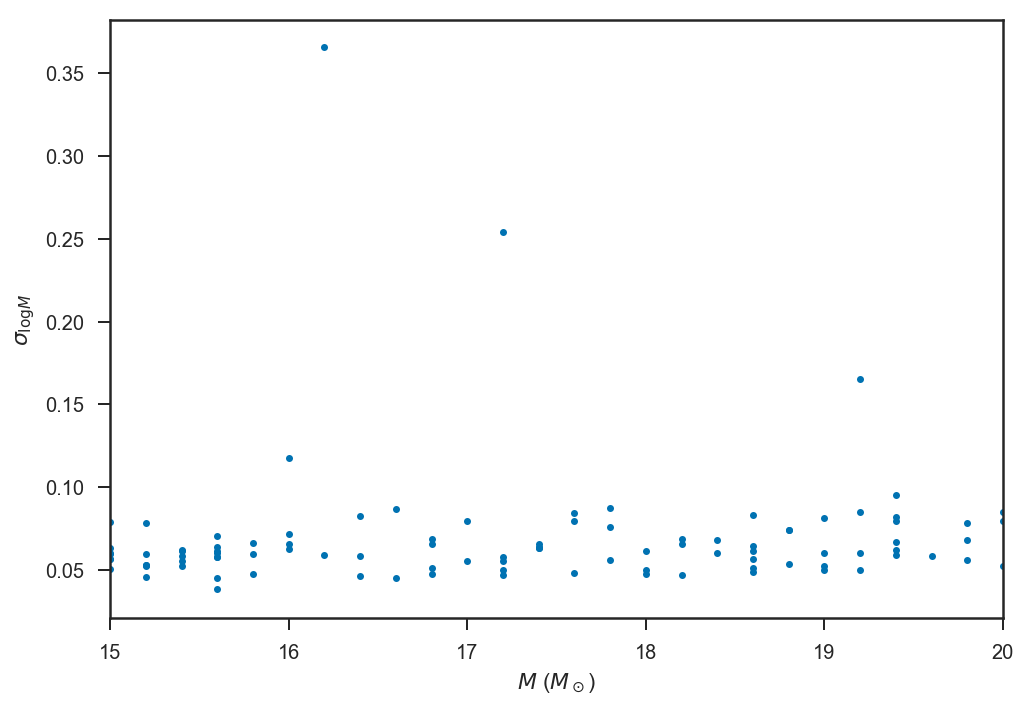

In [15]:
plot(stellar_parameters['Mini'], sigma_logm_obs, '.')
axis(xmin=15, xmax=20)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\sigma_{\log M}$')

sigma_logm_typ = median(sigma_logm_obs[stellar_parameters['Mini']>15])

print('Median (i.e. typical) sigma_logm is {:.2f}'.format(sigma_logm_typ))

We use ``sigma_logm_typ`` to implement selection effects in the integral over the un-observed systems.

## Fitting

First, some utility functions:

In [16]:
def dump_fit(model, fit, file):
    chain = fit.extract(permuted=True)
    
    with bz2.BZ2File(file, 'w') as out:
        pickle.dump(model, out)
        pickle.dump(fit, out)
        pickle.dump(chain, out)
        
def load_fit(file):
    with bz2.BZ2File(file, 'r') as inp:
        model = pickle.load(inp)
        fit = pickle.load(inp)
        chain = pickle.load(inp)
        
    return (model, fit, chain)

The model we use is defined in `IMF.stan`.

In [17]:
model = pystan.StanModel(file='IMF.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_858d50028e18eb707c5a4d0947b864bb NOW.


We only consider systems that have formed in the last $25 \, \Myr$, and select systems above $15 \, \MSun$ (mass at which the survey becomes complete) in their quoted (MAP?) mass.

In [18]:
MCut = 15.0
tMax = 25.0

sel = stellar_parameters['Mini'] > MCut

In [19]:
MMin = exp(so.brentq(lambda lmm: ss.norm(loc=log(MCut), scale=sigma_logm_typ).cdf(lmm) - 0.0001, log(1), log(15)))
print("MMin = ", MMin)

MMin =  11.1152850312


In [20]:
data = {
    'nltc': len(c_lifetime),
    'ltc': c_lifetime,
    
    'MMin': MMin,
    'MCut': MCut,
    'tmax': tMax,
    'sigma_logM_typ': sigma_logm_typ,
    
    'nobs': count_nonzero(sel),
    'log_Mobs': logm_obs[sel],
    'sigma_logM': sigma_logm_obs[sel],
    'ageobs': t_obs[sel],
    'sigma_age': sigma_t_obs[sel],
}

In [21]:
fit = model.sampling(data=data, iter=2000, thin=1)

In [22]:
fit

Inference for Stan model: anon_model_858d50028e18eb707c5a4d0947b864bb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   365.93    0.63  39.75 298.47 338.53 362.55 389.53 451.81   4000    1.0
alpha                 1.98  2.0e-3   0.13   1.74   1.89   1.98   2.07   2.24   4000    1.0
mu_t                  4.47  3.5e-3   0.22   4.06   4.32   4.47   4.62   4.93   4000    1.0
sigma_t               2.21  3.3e-3   0.21   1.85   2.06   2.19   2.34   2.67   4000    1.0
Mtrue[0]              62.6    0.16   10.4  44.61  55.27  61.73  69.07  85.42   4000    1.0
Mtrue[1]             18.98    0.02    1.0  17.08  18.28  18.99  19.65  20.98   4000    1.0
Mtrue[2]             25.98    0.05   3.29  20.13   23.7  25.72  27.91  33.02   4000    1.0
Mtrue[3]             92.87    0.19  12.01  71.16  84.34  92.23 100.31  118.7   4000

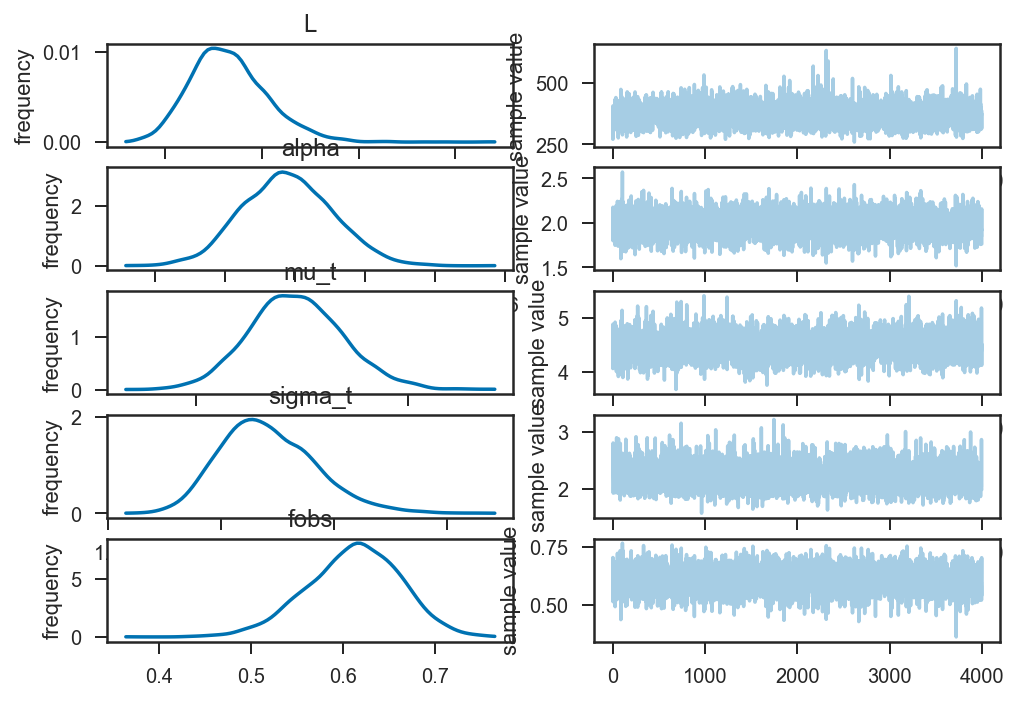

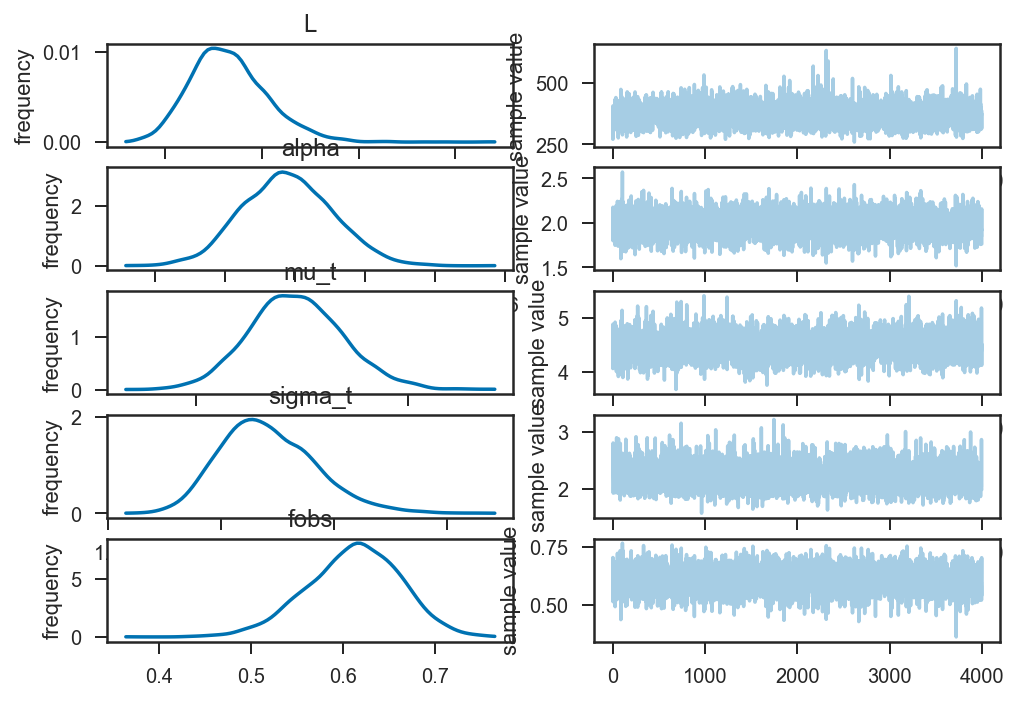

In [23]:
fit.plot(["L", "alpha", "mu_t", "sigma_t", 'fobs'])

In [24]:
chain = fit.extract(permuted=True)

In [25]:
dump_fit(model, fit, 'sampling.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [26]:
_, fit, chain = load_fit('sampling.pkl.bz2')

Let's do a run where we restrict to $M > 20 \, \MSun$. 

In [27]:
MCut_high = 20

sel_high = stellar_parameters['Mini'] >= MCut_high

MMin_high = exp(so.brentq(lambda lmm: ss.norm(loc=lmm, scale=sigma_logm_typ).cdf(log(MCut_high)) - 0.99999, log(1), log(30)))
print("MMin = ", MMin_high)

MMin =  14.1825065989


In [28]:
data_high_mass = data.copy()

data_high_mass['MMin'] = MMin_high
data_high_mass['MCut'] = MCut_high

data_high_mass['nobs'] = count_nonzero(sel_high)
data_high_mass['log_Mobs'] = logm_obs[sel_high]
data_high_mass['sigma_logM'] = sigma_logm_obs[sel_high]
data_high_mass['ageobs'] = t_obs[sel_high]
data_high_mass['sigma_age'] = sigma_t_obs[sel_high]

In [29]:
fit_high_mass = model.sampling(data=data_high_mass, iter=2000, thin=1)

In [30]:
fit_high_mass

Inference for Stan model: anon_model_858d50028e18eb707c5a4d0947b864bb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   211.23    0.46  28.92 163.03  191.1 208.43 227.39 278.29   4000    1.0
alpha                  2.1  2.6e-3   0.17   1.79   1.99    2.1   2.21   2.44   4000    1.0
mu_t                   3.7  3.9e-3   0.25   3.27   3.53   3.68   3.85   4.23   4000    1.0
sigma_t               1.73  3.7e-3   0.23   1.36   1.57    1.7   1.85   2.23   4000    1.0
Mtrue[0]             62.33    0.16  10.12   44.7  55.32  61.54   68.7   84.4   4000    1.0
Mtrue[1]             25.91    0.05   3.19  20.35  23.66  25.65  27.95  32.71   4000    1.0
Mtrue[2]             92.66    0.18  11.58  71.61  84.65  91.71 100.09 117.65   4000    1.0
Mtrue[3]             20.15    0.02   1.57   17.2  19.07  20.08  21.18  23.46   4000

In [31]:
chain_high_mass = fit_high_mass.extract(permuted=True)

In [32]:
dump_fit(model, fit_high_mass, 'sampling-high-mass.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [33]:
_, fit_high_mass, chain_high_mass = load_fit('sampling-high-mass.pkl.bz2')

## Analysis

Code to draw synthetic observations from a posterior sample.

In [34]:
def draw_systems(fit, chain):
    d = fit.data
    
    i = randint(chain['L'].shape[0])
    L = chain['L'][i]
    fobs = chain['fobs'][i]
    alpha = chain['alpha'][i]
    mu = chain['mu_t'][i]
    sigma = chain['sigma_t'][i]
    
    # The distribution is normalised to MCut in the code, but masses can actually be M > MMin
    N = random.poisson(L*d['MMin']**(1-alpha)/d['MCut']**(1-alpha))
    ts = mu + sigma*randn(N)
    while any(ts<0) or any(ts>d['tmax']):
        ts[ts<0] = mu + sigma*randn(count_nonzero(ts<0))
        ts[ts>d['tmax']] = mu + sigma*randn(count_nonzero(ts>d['tmax']))
    ms = d['MMin']*(1-random.uniform(size=N))**(1.0/(1.0-alpha))
    
    # Cut down to main sequence objects
    ms, ts = zip(*[(m,t) for m,t in zip(ms,ts) if t < lifetime(m, c_lifetime)])
    
    # Now get observational errors
    ms_out = []
    dms_out = []
    ts_out = []
    dts_out = []
    
    for m,t in zip(ms, ts):
        sigma_logm = random.choice(d['sigma_logM'])
        sigma_t = random.choice(d['sigma_age'])
        
        dms_out.append(sigma_logm)
        dts_out.append(sigma_t)
        
        mo = exp(ss.norm.rvs(loc=log(m), scale=sigma_logm))
        ms_out.append(mo)
        
        to = -1.0
        while to < 0:
            to = ss.norm.rvs(loc=t, scale=sigma_t)
        ts_out.append(to)
        
    ms_out = array(ms_out)
    dms_out = array(dms_out)
    ts_out = array(ts_out)
    dts_out = array(dts_out)

    sel = ms_out > d['MCut']
        
    return ms_out[sel], dms_out[sel], ts_out[sel], dts_out[sel]

Some useful plotting code:

In [35]:
def plot_dNdM(fit, chain, MMax=200.0, down_select=False, *args, **kwargs):
    MMin = fit.data['MCut']
    
    ms = logspace(log10(MMin), log10(MMax), 1000)[newaxis,:]
    
    alphas = chain['alpha'][:,newaxis]
    Ls = chain['L'][:,newaxis]
    
    dNdMs = Ls*(alphas-1)/MMin*(ms/MMin)**(-alphas)
    
    if down_select:
        mu_t = chain['mu_t']
        sigma_t = chain['sigma_t']
        
        sfactors = array([(ss.norm.cdf(lifetime(m, c_lifetime), loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t)-ss.norm.cdf(0, loc=mu_t, scale=sigma_t)) for m in ms[0,:]])
    
        dNdMs = dNdMs * sfactors.T
        
    m = median(dNdMs, axis=0)
    h = percentile(dNdMs, 84.0, axis=0)
    hh = percentile(dNdMs, 97.5, axis=0)
    l = percentile(dNdMs, 16.0, axis=0)
    ll = percentile(dNdMs, 2.5, axis=0)
    
    ms = ms[0,:]
    
    line, = loglog(ms, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ms, h, l, color=c, alpha=0.25)
    fill_between(ms, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$M$ ($M_\odot$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
    
def plot_dNdt(chain, tmax=25.0, down_select=False, *args, **kwargs):
    ts = linspace(0, tmax, 1000)[newaxis,:]
    
    Ls = chain['L'][:,newaxis]
    mu_t = chain['mu_t'][:,newaxis]
    sigma_t = chain['sigma_t'][:,newaxis]
    
    dNdts = Ls*ss.norm.pdf(ts, loc=mu_t, scale=sigma_t)/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))

    if down_select:
        alphas = chain['alpha'][:,newaxis]
        
        mupper = []
        for t in ts[0,:]:
            if t < lifetime(1000.0, c_lifetime):
                mupper.append(np.inf)
            else:
                mupper.append(so.brentq((lambda m: lifetime(m, c_lifetime)-t), 10.0, 1000.0))
        mupper = array(mupper)
        
        sfactors = 1-(mupper/MCut)**(1-alphas)
        
        dNdts = dNdts * sfactors
    
    ts = ts[0,:]
    
    m = median(dNdts, axis=0)
    h = percentile(dNdts, 84.0, axis=0)
    hh = percentile(dNdts, 97.5, axis=0)
    l = percentile(dNdts, 16.0, axis=0)
    ll = percentile(dNdts, 2.5, axis=0)
    
    line, = plot(ts, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ts, h, l, color=c, alpha=0.25)
    fill_between(ts, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$t$ ($\mathrm{Mya}$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')

Some code that can convert a sample of masses and ages into a density:

In [36]:
def empirical_dNdM(ms, mmin=15.0):
    logms = log(ms)
    
    kde = ss.gaussian_kde(logms)
    
    def dNdM(m):
        return ms.shape[0]*(kde(log(m)) + kde(2*log(mmin)-log(m)))/m
    return dNdM
def empirical_dNdt(ts, tmax=25.0):
    kde = ss.gaussian_kde(ts)
    
    def dNdt(t):
        return ts.shape[0]*(kde(t) + kde(-t) + kde(2*tmax-t))
    
    return dNdt

Execute the cell below to re-load the fits.  If you want to be sure that the model code matches, you can change the `_` to `model` to re-load the model as well, but it is probably safer to re-run the cell above where the model is compiled.

In [37]:
_, fit, chain = load_fit('sampling.pkl.bz2')
_, fit_high_mass, chain_high_mass = load_fit('sampling-high-mass.pkl.bz2')

First, the headline result, analagous to Schneider, et al. (2018) Figure 1 (in two panels).  We plot $\diff{N}{M}$ and $\diff{N}{t}$ from 
* The model (i.e. all stars).
* The observable stars (those with lifetime long enough to be on the main sequence today).
* The empirical $\diff{N}{M}$ or $\diff{N}{t}$.

*Note*: This plot may not be as meaningful as you think it is.  The empirical distribution is a convolution of the observable distribution and observational errors, so one would not expect (and, indeed, does not see) that these distributions match particularly well.  See below for comparisions *in data space* between model and data (these are known as "posterior predictive checks").

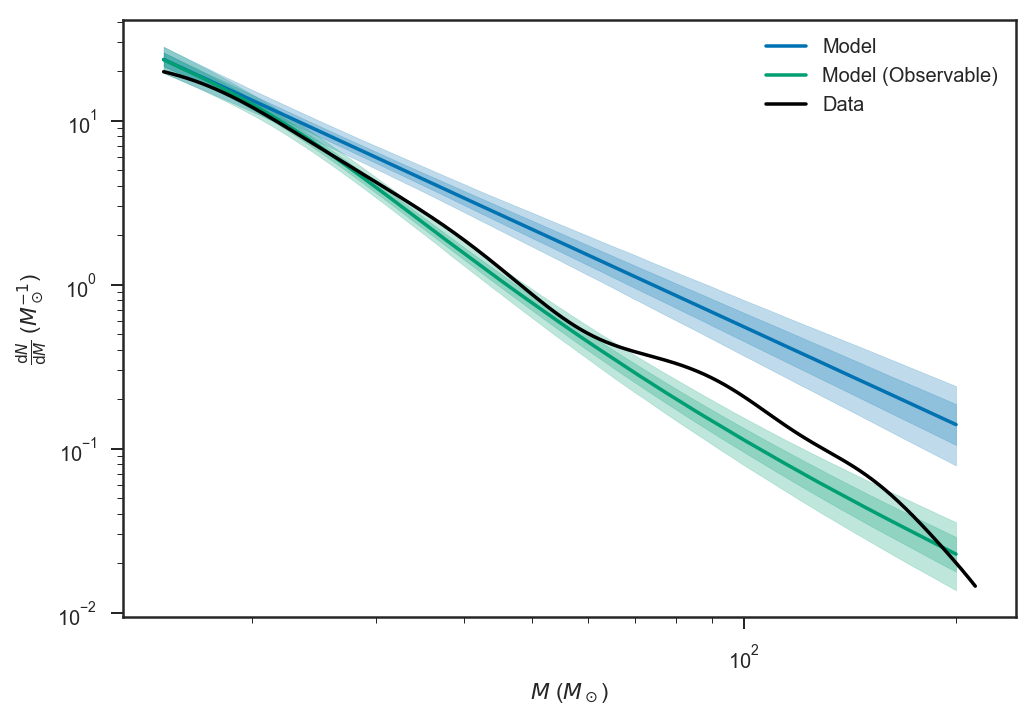

In [38]:
plot_dNdM(fit, chain, label='Model')
plot_dNdM(fit, chain, label='Model (Observable)', down_select=True)
ms = linspace(MCut, np.max(stellar_parameters['Mini'])+10, 1000)
plot(ms, empirical_dNdM(stellar_parameters['Mini'][stellar_parameters['Mini']>MCut])(ms), label='Data', color='k')
legend(loc='best')

savefig('dNdM-model.pdf')

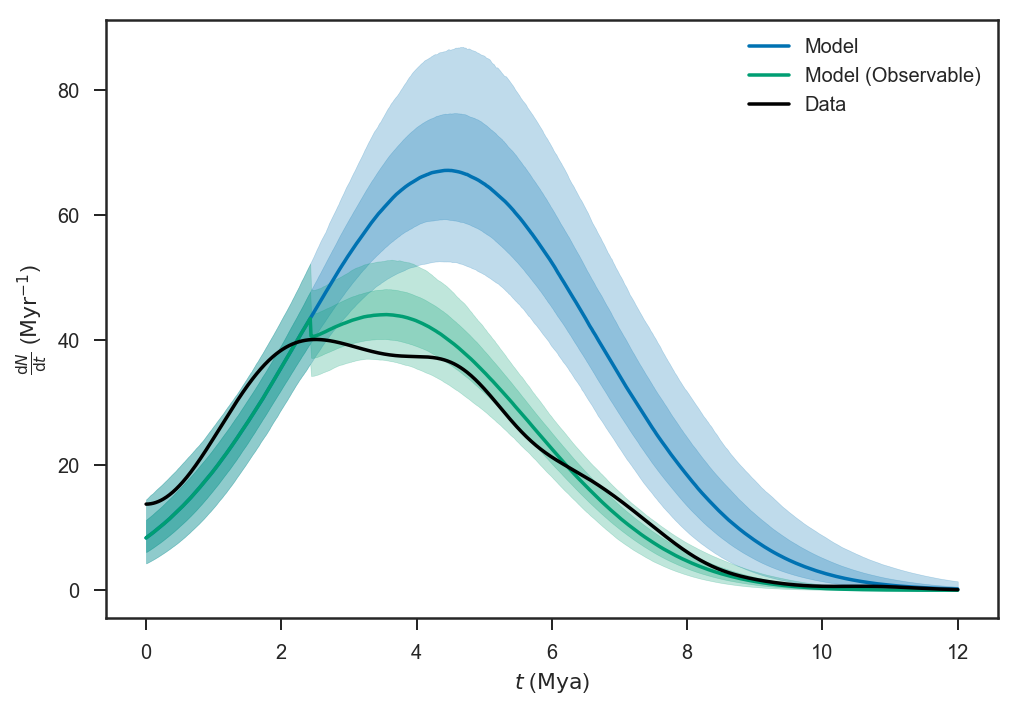

In [39]:
plot_dNdt(chain, tmax=12, label='Model')
plot_dNdt(chain, tmax=12, down_select=True, label='Model (Observable)')
ts = linspace(0, 12, 1000)
plot(ts, empirical_dNdt(stellar_parameters['age'][stellar_parameters['Mini']>MCut])(ts), color='k', label='Data')
legend(loc='best')

savefig('dNdt-model.pdf')

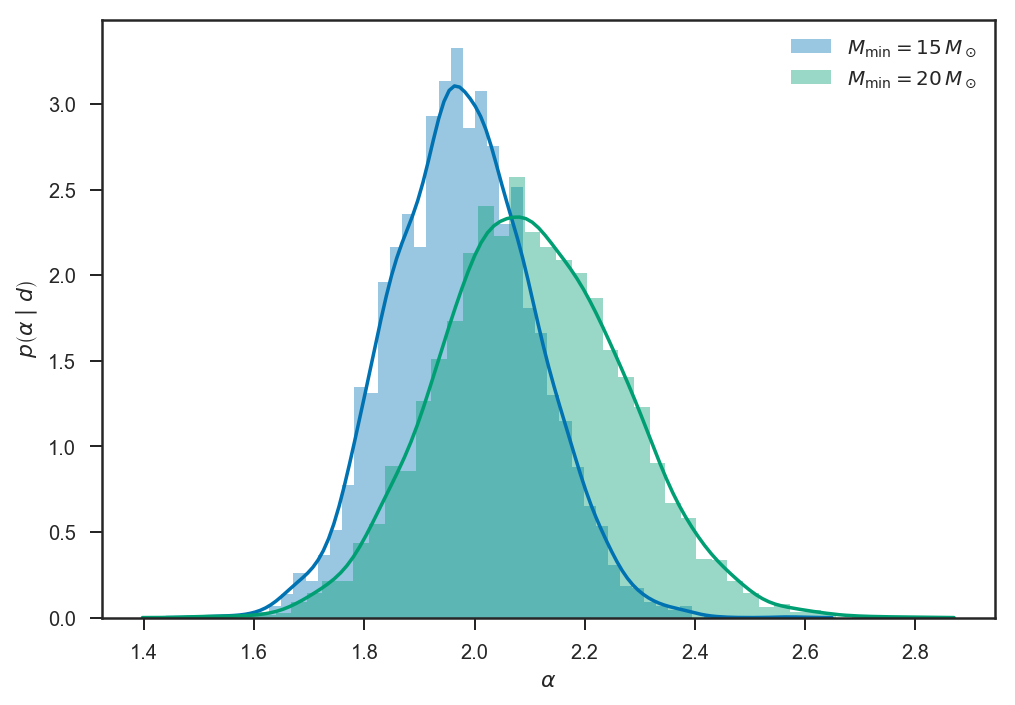

In [40]:
sns.distplot(chain['alpha'], label=r'$M_\mathrm{min} = 15 \, M_\odot$')
sns.distplot(chain_high_mass['alpha'], label=r'$M_\mathrm{min} = 20 \, M_\odot$')
legend(loc='best')

xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \mid d \right)$')

#savefig('alpha.pdf')

Given the posterior predictive checks (see below) that suggest that there is nothing strange about the shift from the $M \geq 20 \, \MSun$ cut, we decided not to show it in the figure for publication.

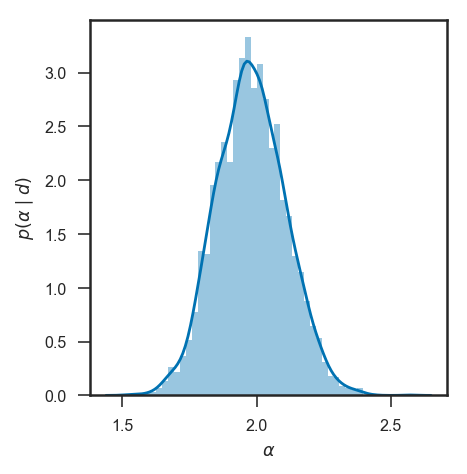

In [41]:
with sns.plotting_context('paper', rc=pubrc):
    sns.distplot(chain['alpha'], label=r'$M_\mathrm{min} = 15 \, M_\odot$, $\nu = 100$')
    #sns.distplot(chain_high_mass['alpha'], label=r'$M_\mathrm{min} = 20 \, M_\odot$, $\nu = 100$')
    
    #legend(loc='best')

    xlabel(r'$\alpha$')
    ylabel(r'$p\left( \alpha \mid d \right)$')
    
    tight_layout()

    savefig('alpha.pdf')

In [42]:
def one_sigma_range(samples):
    m = median(samples)
    h = percentile(samples, 84)
    l = percentile(samples, 16)
    
    return m, h-m, m-l

In [43]:
print('Found alpha = {:.2f} + {:.2f} - {:.2f}'.format(*one_sigma_range(chain['alpha'])))

Found alpha = 1.98 + 0.13 - 0.13


In [44]:
print('Found alpha = {:.2f} + {:.2f} - {:.2f} (Mmin = 20)'.format(*one_sigma_range(chain_high_mass['alpha'])))

Found alpha = 2.10 + 0.17 - 0.16 (Mmin = 20)


These plots don't really address the fundamental issue, however, since we are plotting *theoretically* observable curves against *raw observational data*.  It is better to use the code above to draw synthetic observations, and compare them.  Such a comparison goes by the fancy name "graphical posterior predictive check."  One can think of it as our *uncertainty distribution in data space* for repeated observations of a system just like 30 Dor with the same uncertanties, etc.  It provides a useful check on the end-to-end model (remember, synthetic observations are drawn from the synthetic likelihood function---a Student-T); if the observed data do not fall within reasonable bounds for this distribution, then very likely there is a problem with the model.  That is clearly not the case here.

Here is a quick check that the synthetic observations are generated reasonably:

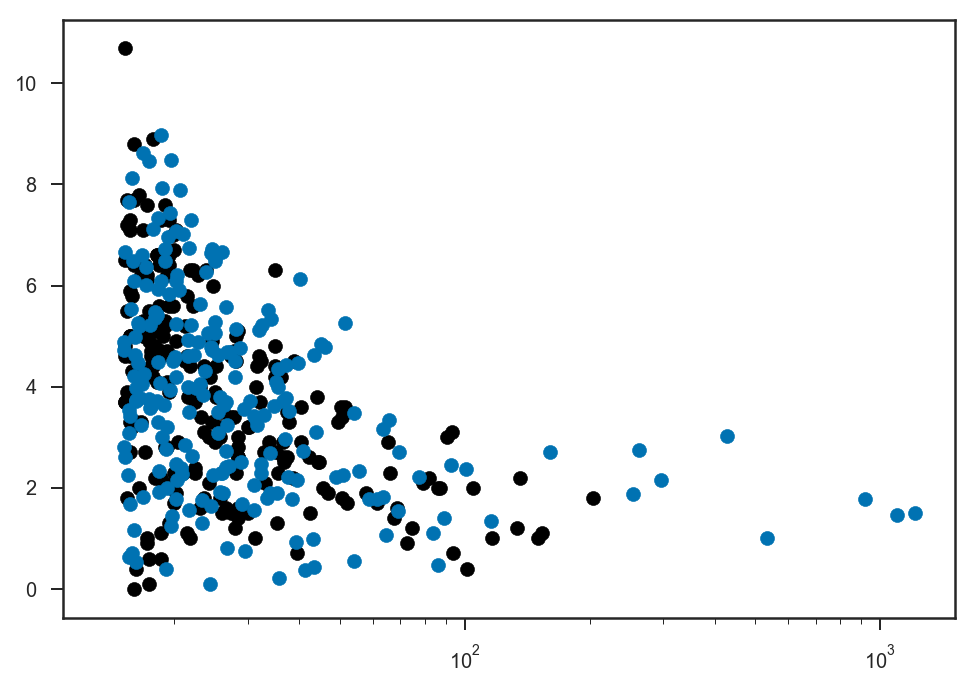

In [45]:
ms, dms, ts, dts = draw_systems(fit, chain)
scatter(stellar_parameters['Mini'][stellar_parameters['Mini']>MCut], stellar_parameters['age'][stellar_parameters['Mini']>MCut], color='k')
scatter(ms, ts, color=sns.color_palette()[0])
xscale('log')

And here is a plot of the empirical $\diff{N}{M}$ for the actual data and the synthetic observations:

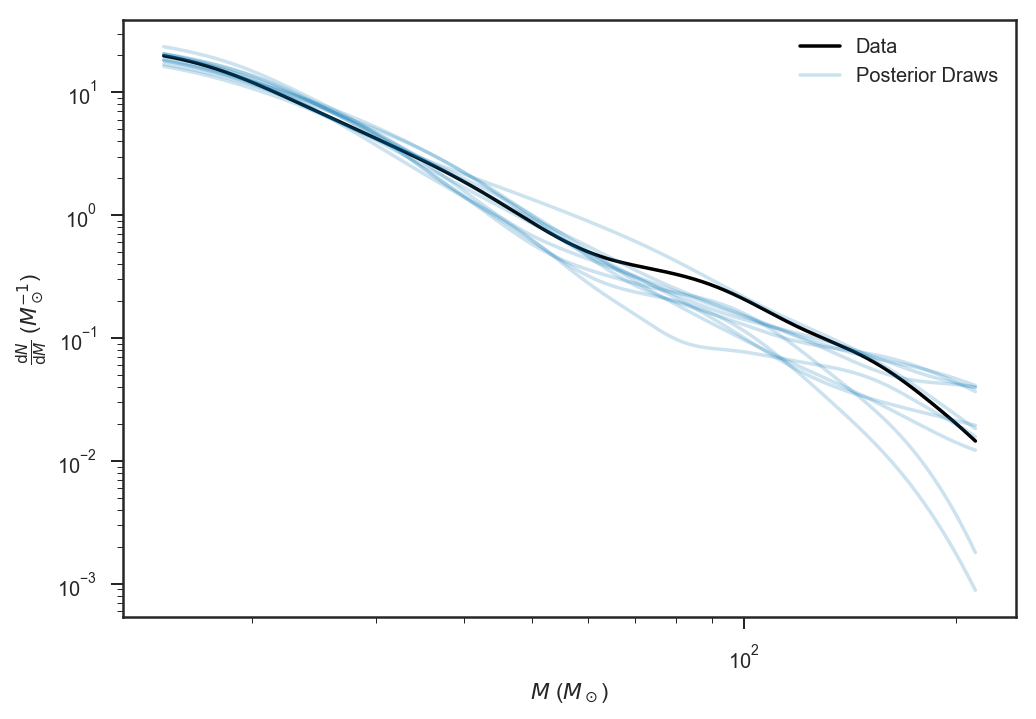

In [46]:
ms = logspace(log10(MCut), log10(np.max(stellar_parameters['Mini'])+10), 1000)
plot(ms, empirical_dNdM(stellar_parameters['Mini'][stellar_parameters['Mini']>MCut])(ms), color='k', label='Data')

for i in range(10):
    ms_draw, _, _, _ = draw_systems(fit, chain)
    if i == 0:
        l = 'Posterior Draws'
    else:
        l = None
    plot(ms, empirical_dNdM(ms_draw)(ms), color=sns.color_palette()[0], alpha=0.2, label=l)
yscale('log')
xscale('log')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
legend(loc='best')

savefig('dNdM-ppc-lightning.pdf')

Or, here is an alternate version of this figure:

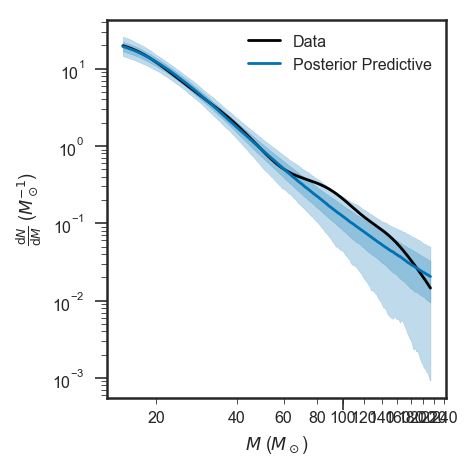

In [47]:
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%1i' % (x)

with sns.plotting_context('paper', rc=pubrc):
    ax = subplot(111)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    formatter = FuncFormatter(log_10_product)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(formatter)
    
    xlocator = MultipleLocator(20)
    ax.xaxis.set_minor_locator(xlocator)
    
    ms = logspace(log10(MCut), log10(np.max(stellar_parameters['Mini'])+10), 1000)
    ax.plot(ms, empirical_dNdM(stellar_parameters['Mini'][stellar_parameters['Mini']>MCut])(ms), color='k', label='Data')

    edNdMs = []
    for i in range(1000):
        ms_draw, _, _, _ = draw_systems(fit, chain)
        edNdMs.append(empirical_dNdM(ms_draw)(ms))
    edNdMs = array(edNdMs)

    ax.plot(ms, median(edNdMs, axis=0), color=sns.color_palette()[0], label='Posterior Predictive')
    ax.fill_between(ms, percentile(edNdMs, 84, axis=0), percentile(edNdMs, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
    ax.fill_between(ms, percentile(edNdMs, 97.5, axis=0), percentile(edNdMs, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)

    ax.set_xlabel(r'$M$ ($M_\odot$)')
    ax.set_ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
    ax.legend(loc='best')
    
    tight_layout()
    
    savefig('dNdM-ppc-band.pdf')

And the same for age:

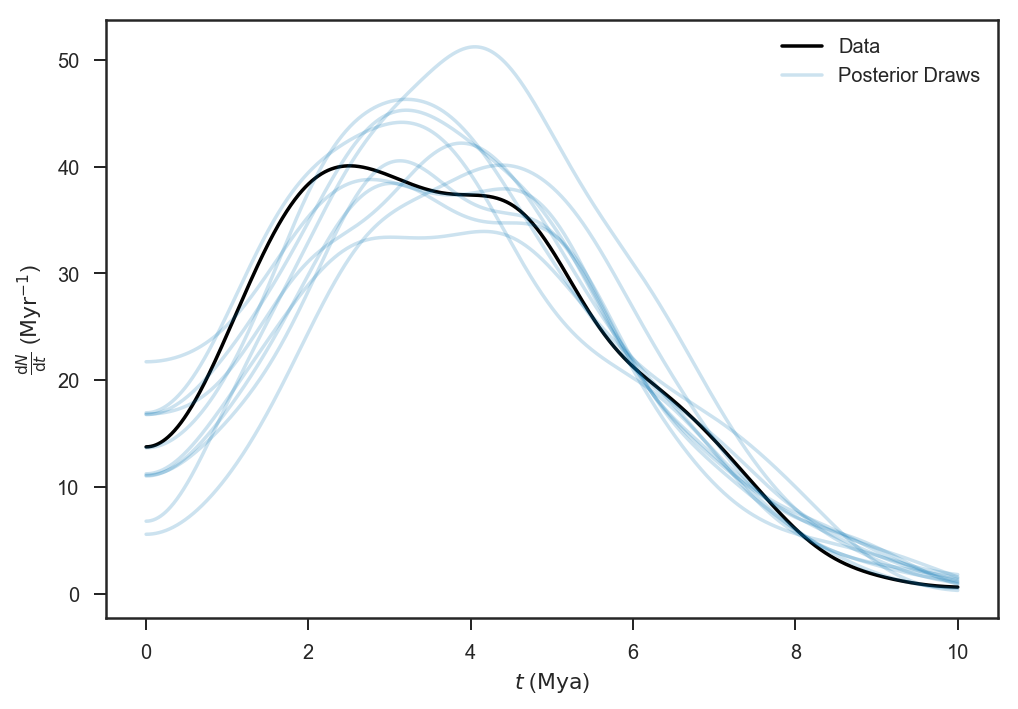

In [48]:
ts = linspace(0, 10, 1000)
plot(ts, empirical_dNdt(stellar_parameters['age'][stellar_parameters['Mini']>MCut])(ts), color='k', label='Data')

for i in range(10):
    _, _, ts_draw, _ = draw_systems(fit, chain)
    if i == 0:
        l = 'Posterior Draws'
    else:
        l = None
    plot(ts, empirical_dNdt(ts_draw)(ts), color=sns.color_palette()[0], alpha=0.2, label=l)
xlabel(r'$t$ ($\mathrm{Mya}$)')
ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')
legend(loc='best')

savefig('dNdt-ppc-lightning.pdf')

And, as before, an alternate version of the figure:

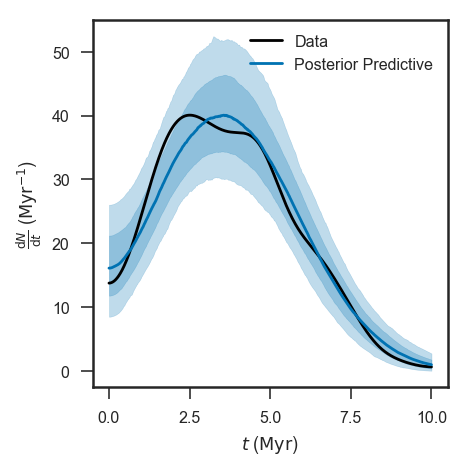

In [49]:
with sns.plotting_context('paper', rc=pubrc):

    ts = linspace(0, 10, 1000)
    plot(ts, empirical_dNdt(stellar_parameters['age'][stellar_parameters['Mini']>MCut])(ts), color='k', label='Data')

    edNdts = []
    for i in range(1000):
        _, _, ts_draw, _ = draw_systems(fit, chain)
        edNdts.append(empirical_dNdt(ts_draw)(ts))
    edNdts = array(edNdts)

    plot(ts, median(edNdts, axis=0), color=sns.color_palette()[0], label='Posterior Predictive')
    fill_between(ts, percentile(edNdts, 84, axis=0), percentile(edNdts, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
    fill_between(ts, percentile(edNdts, 97.5, axis=0), percentile(edNdts, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
    xlabel(r'$t$ ($\mathrm{Myr}$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')
    legend(loc='best')
    
    tight_layout()

    savefig('dNdt-ppc-band.pdf')

### Stars Heavier Than $30 \, \MSun$ and $60\, \MSun$

In [50]:
n30 = []
n60 = []
for i in range(1000):
    m, dm, t, dt = draw_systems(fit, chain)
    n30.append(count_nonzero(m > 30))
    n60.append(count_nonzero(m > 60))
n30 = array(n30)
n60 = array(n60)

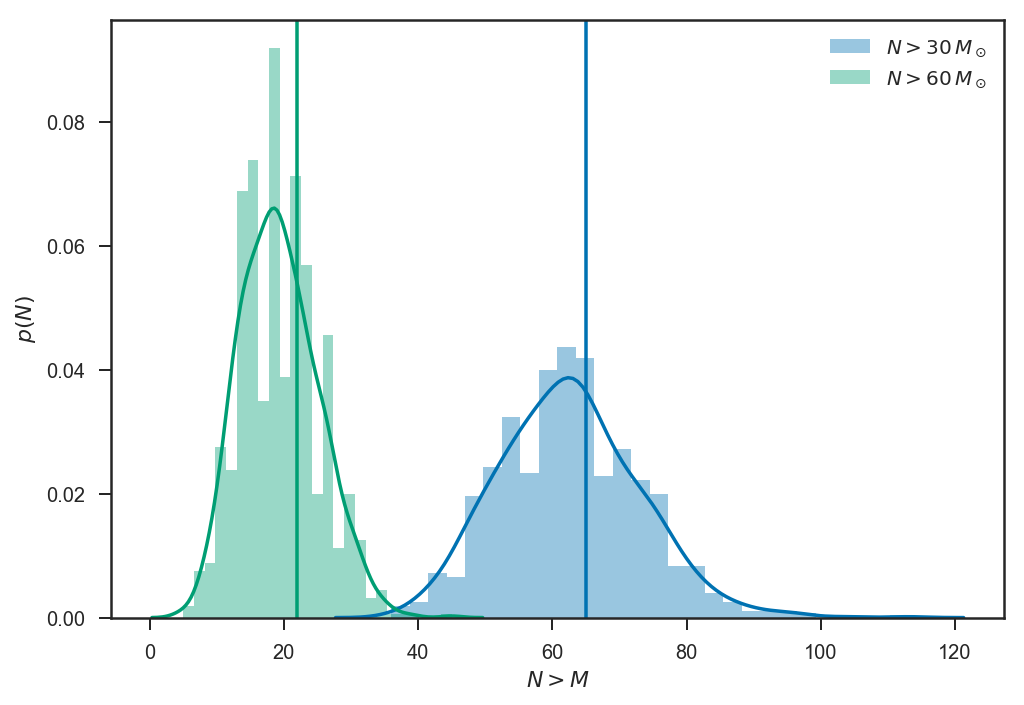

In [51]:
sns.distplot(n30, label=r'$N > 30 \, M_\odot$')
sns.distplot(n60, label=r'$N > 60 \, M_\odot$')
axvline(count_nonzero(stellar_parameters['Mini'] > 30), color=sns.color_palette()[0])
axvline(count_nonzero(stellar_parameters['Mini'] > 60), color=sns.color_palette()[1])
xlabel(r'$N > M$')
ylabel(r'$p\left( N \right)$')
legend(loc='best')

In [52]:
(count_nonzero(stellar_parameters['Mini'] > 30)), (count_nonzero(stellar_parameters['Mini'] > 60)), (count_nonzero(stellar_parameters['Mini'] > 30))/(count_nonzero(stellar_parameters['Mini'] > 60))

(65, 22, 2.9545454545454546)

In [53]:
sum(stellar_parameters['Mini']>15)

223

### PPC Check for Chages at 20 MSun

**This section has not been updated with the latest results, as the difference between the two fits does not seem very surprising any more.**

There is a surprisingly large shift in the distribution for $\alpha$ when $M > 20 \, \MSun$ is used for the completeness cut instead of $15\, \MSun$.  Let's see if that is reasonable under the model (i.e. via PPC).

In [51]:
chains_complete_ppc = []
datas_complete_ppc = []
fits_complete_ppc = []

In [56]:
for i in range(5):
    ms, dms, ts, dts = draw_systems(fit, chain)

    cutsel = ms > MCut_high
    ms = ms[cutsel]
    dms = dms[cutsel]
    ts = ts[cutsel]
    dts = dts[cutsel]

    data_complete_ppc = {
        'nltc': len(c_lifetime),
        'ltc': c_lifetime,
        
        'MMin': MMin_high,
        'MCut': MCut_high,
        'tmax': fit.data['tmax'],
        'sigma_logM_typ': sigma_logm_typ,

        'nobs': len(ms),
        'log_Mobs': log(ms),
        'sigma_logM': dms,
        'ageobs': ts,
        'sigma_age': dts
    }

    fit_complete_ppc = model.sampling(data=data_complete_ppc)
    print(fit_complete_ppc)

    chain_complete_ppc = fit_complete_ppc.extract(permuted=True)

    fits_complete_ppc.append(fit_complete_ppc)
    chains_complete_ppc.append(chain_complete_ppc)
    datas_complete_ppc.append(data_complete_ppc)

Inference for Stan model: anon_model_9517850b9f2618bbc73e84358529d465.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                    220.9     0.8  36.04 166.86 196.59 215.79 239.37 306.09   2024    1.0
alpha                  2.6  3.5e-3   0.22   2.18   2.45   2.59   2.74   3.04   4000    1.0
mu_t                  4.26  8.4e-3   0.39   3.64   3.99   4.21   4.46   5.17   2206    1.0
sigma_t               2.14  8.7e-3   0.38    1.6   1.87   2.07   2.32   3.07   1922    1.0
Mtrue[0]             32.96    0.06   3.78  26.37  30.38   32.7  35.21  41.27   4000    1.0
Mtrue[1]             27.84    0.03   1.88  24.37  26.52  27.76  29.04  31.71   4000    1.0
Mtrue[2]             23.93    0.03   1.98  20.31  22.56  23.87   25.2  28.04   4000    1.0
Mtrue[3]             22.96    0.02   1.34  20.45  22.03  22.95  23.81  25.71   4000

Inference for Stan model: anon_model_9517850b9f2618bbc73e84358529d465.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   197.16    6.48 109.28 123.97 149.28  167.4 195.78 550.13    284   1.02
alpha                  2.4  3.2e-3    0.2   2.02   2.26   2.39   2.53    2.8   4000    1.0
mu_t                  4.24    0.14   2.31    2.7   3.49   3.77   4.15  10.99    279   1.02
sigma_t               3.34    0.18   3.12   1.67   2.03   2.38   3.04   14.7    288   1.02
Mtrue[0]             27.34    0.04   2.26   23.2  25.73  27.26   28.8  32.03   4000    1.0
Mtrue[1]             20.59    0.02    1.4  17.82  19.61  20.59  21.53  23.43   4000    1.0
Mtrue[2]             28.96    0.03   1.75  25.71  27.72  28.88  30.12  32.62   4000    1.0
Mtrue[3]             28.91    0.03   1.69  25.63  27.77  28.86  30.04  32.22   4000

Inference for Stan model: anon_model_9517850b9f2618bbc73e84358529d465.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   516.66   11.44 366.66 197.95 272.66 386.32 664.68 1428.2   1027    1.0
alpha                 2.52  3.1e-3    0.2   2.13   2.39   2.52   2.65   2.93   4000    1.0
mu_t                  8.37    0.16   5.31   3.58   4.72   5.97  10.35  22.73   1091    1.0
sigma_t               7.06    0.17    4.9   2.32   3.39   5.14   9.37  20.47    799    1.0
Mtrue[0]             44.36    0.04   2.78  39.13  42.54  44.23  46.06  50.25   4000    1.0
Mtrue[1]             23.48    0.05   3.08  18.24  21.29  23.26  25.45  30.03   4000    1.0
Mtrue[2]             20.03    0.03   1.68  16.94  18.85  19.96  21.15  23.51   4000    1.0
Mtrue[3]             21.76    0.06   3.62  15.71  19.14  21.38  24.01  30.06   4000

Inference for Stan model: anon_model_9517850b9f2618bbc73e84358529d465.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                    309.2    3.15 115.19 188.27 241.25 282.83 342.09 590.74   1336    1.0
alpha                 2.06  3.1e-3    0.2   1.69   1.92   2.05   2.18   2.46   4000    1.0
mu_t                  5.43    0.03   0.94   4.34   4.85   5.22   5.72   8.01   1211    1.0
sigma_t               2.43    0.02    0.6    1.7   2.05    2.3   2.63   4.11   1303    1.0
Mtrue[0]             25.48    0.04   2.22  21.45  23.96   25.4  26.88  30.08   4000    1.0
Mtrue[1]             20.68    0.02    1.0  18.79  19.98  20.66  21.33  22.73   4000    1.0
Mtrue[2]             27.98    0.04   2.81  22.82  26.03  27.87  29.77  33.96   4000    1.0
Mtrue[3]              25.3    0.06   3.59  18.97  22.65  25.16   27.6  32.99   4000

Inference for Stan model: anon_model_9517850b9f2618bbc73e84358529d465.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   423.33   19.86 287.18 245.53 318.14 377.25 458.33 775.87    209   1.02
alpha                 1.72  2.5e-3   0.16   1.41    1.6   1.71   1.82   2.04   4000    1.0
mu_t                   5.4     0.1   1.28   4.37   4.85   5.19   5.61   7.49    173   1.03
sigma_t               2.32    0.05   0.67   1.68   1.98    2.2   2.49   3.57    212   1.03
Mtrue[0]             22.52    0.03   1.77  19.28  21.26  22.43  23.68  26.24   4000    1.0
Mtrue[1]            176.71    0.16  10.33 157.49 169.61 176.43 183.41 198.36   4000    1.0
Mtrue[2]             23.99    0.03   1.64  20.94  22.87  23.97  25.07  27.37   4000    1.0
Mtrue[3]             21.23    0.03   1.81  17.94  19.99  21.16  22.41  25.04   4000

In [58]:
with bz2.BZ2File('sampling-complete-ppc.pkl.bz2', 'w') as out:
    pickle.dump(model, out)
    pickle.dump(fits_complete_ppc, out)
    pickle.dump(chains_complete_ppc, out)

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


Execute this cell to re-load the data, fits, and chains from the PPC at $20 \, \MSun$ threshold:

In [45]:
with bz2.BZ2File('sampling-complete-ppc.pkl.bz2', 'r') as inp:
    _ = pickle.load(inp) # This will load the model, but hopefully you have just compiled above
    fits_complete_ppc = pickle.load(inp)
    chains_complete_ppc = pickle.load(inp)
datas_complete_pcc = [f.data for f in fits_complete_ppc]

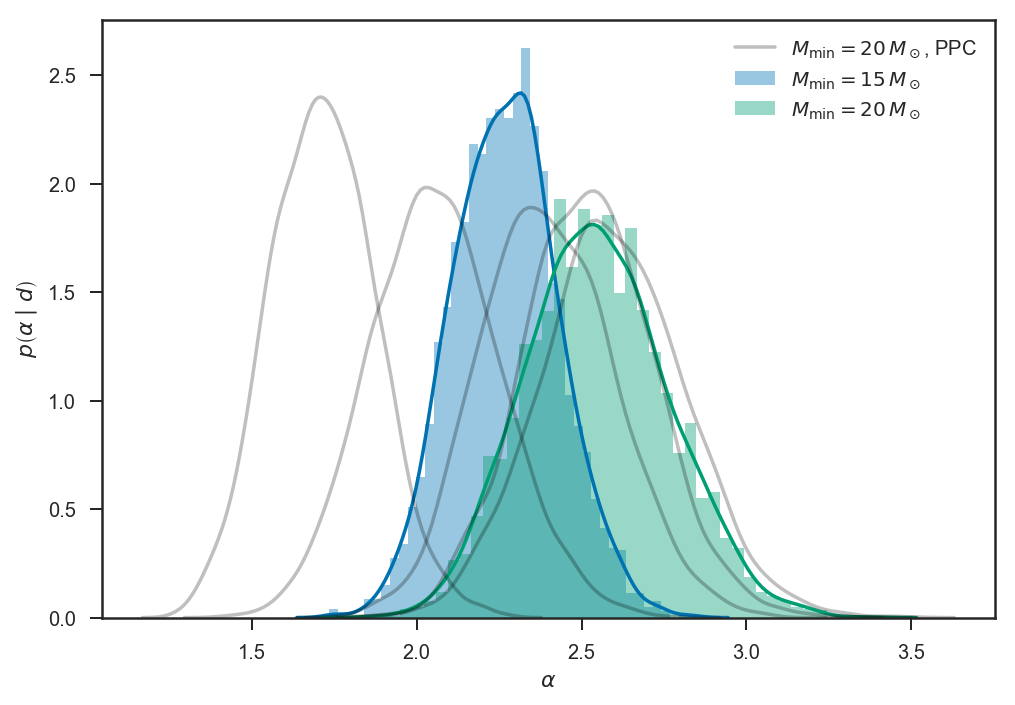

In [57]:
sns.distplot(chain['alpha'], label=r'$M_\mathrm{min} = 15 \, M_\odot$')
sns.distplot(chain_high_mass['alpha'], label=r'$M_\mathrm{min} = 20 \, M_\odot$')
for (i, c) in enumerate(chains_complete_ppc):
    if i == 0:
        sns.kdeplot(c['alpha'], alpha=0.25, color='k', label=r'$M_\mathrm{min} = 20 \, M_\odot$, PPC')
    else:
        sns.kdeplot(c['alpha'], alpha=0.25, color='k')
legend(loc='best')

xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \mid d \right)$')

savefig('alpha-ppc.pdf')